In [16]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import matplotlib
import argparse
import torch.optim as optim
import time
import os

dataset_dir = '../../../Project/CNN-VAE/data'
image_size = 96
class CombinedResNet(nn.Module):
    def __init__(self):
        super(CombinedResNet, self).__init__()
        full_resnet = torchvision.models.resnet18()
        self.resnet = nn.Sequential(*list(full_resnet.children())[0:-1])
        num_features = full_resnet.fc.in_features
        self.fc = nn.Linear(9 * num_features, 100)

    def forward(self, x):
        x1 = torch.zeros(x.shape[0], 9, 512, 1, 1).to(x.device)
        for i in range(9):
            x1[:, i] = self.resnet(x[:, i])
        x = x1.reshape(x1.shape[0], -1)
        return self.fc(x)
    

# This is a model which takes an existing network, and adds a fc layer to the end of it. 
# Used to create the ResNet18 from the network loaded from the pretext task
class TransferNet(nn.Module):
    def __init__(self, net):
        super(TransferNet, self).__init__()
        self.resnet = net
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = x.reshape(x.shape[0], -1)
        return self.fc(x)

net = CombinedResNet()
net = TransferNet(net.resnet)
# Load existing network (the one trained on the pretext task), and convert the ResNet contained in it into a
# TransferNet to add the fc layer back onto it
if os.path.isfile('classifier.pt'):
    # Raise Error if it does not exist
    print("Checkpoint does not exist, starting from scratch")
    check_point = torch.load('classifier.pt', map_location=torch.device('cpu'))
    net.load_state_dict(check_point['model_state_dict'])
else:
    raise ValueError("Rotation classifier does not exist")
    
    
# Perform random crops and mirroring for data augmentation
transform_train = transforms.Compose(
    [transforms.RandomCrop(image_size, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# No random
transform_test = transforms.Compose(
    [transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    
# Create training and validation split
# Load train and validation sets
train_val_set = STL10(dataset_dir, split='train', transform=transform_train, download=False)

# Use 10% of data for training - simulating low data scenario
num_train = int(len(train_val_set) * 0.1)

# Split data into train/val sets
# Set torch's random seed so that random split of data is reproducible
torch.manual_seed(0)
train_set, val_set = random_split(train_val_set, [num_train, len(train_val_set) - num_train])

test_set = STL10(dataset_dir, split='test', transform=transform_test, download=False)

Checkpoint does not exist, starting from scratch


tensor([[-2.9917, -4.7365, -5.6738, -6.5656, -5.3649, -5.1239, -4.6792, -4.1167,
         -8.7151, -6.3254]], grad_fn=<AddmmBackward>)


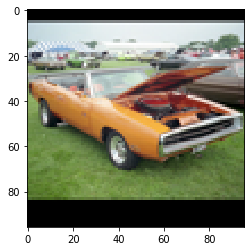

In [28]:
def normalize_img(img):
    mins = img.min()
    maxs = img.max()
    return (img - mins)/(maxs - mins)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
image, label = test_set[103]
print(net(image.unsqueeze(0)))
plt.imshow(normalize_img(np.moveaxis(image.numpy(), 0, 2)))